# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [331]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time
from IPython.display import display
# from sklearn.impute import SimpleImputer : cannot use in sklearn ver 0.19.1
from sklearn.preprocessing import Imputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_columns = None  # show all columns

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [183]:
# Read data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv')

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Have a look of each dataset

In [184]:
# azdias
del azdias['Unnamed: 0']
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [4]:
azdias.shape

(891221, 366)

In [185]:
# customers
del customers['Unnamed: 0']
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [6]:
customers.shape

(191652, 369)

In [7]:
# investigate the additional three columns in "CUSTOMER"
customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,SINGLE_BUYER,0,FOOD
2,MULTI_BUYER,0,COSMETIC_AND_FOOD
3,MULTI_BUYER,0,COSMETIC
4,MULTI_BUYER,0,FOOD
5,MULTI_BUYER,0,COSMETIC_AND_FOOD
6,MULTI_BUYER,0,COSMETIC_AND_FOOD
7,SINGLE_BUYER,0,FOOD
8,MULTI_BUYER,0,COSMETIC
9,MULTI_BUYER,0,COSMETIC


In order to deal with the missing/unknown data correctly, import the feature summary data, which is edited originally from "DIAS Attributes - Values 2017.xlsx" file. These are what I did in order to get the feature summary data via Excel.    
1. missing_or_unknown: For the attributes that include unknown fields, I left the correesponding value for it.
2. type: Based on the description and the value, I gave each attribute the types (ordinal/categorical/mixed/numeric), where mixed type means the types include more than one type.
3. One of the arribute name was wrongly typed. I changed the name 'CAMEO_DEUINTL_2015' to 'CAMEO_INTL_2015' in the Excel file.

In [8]:
feature_summary = pd.read_csv('DIAS_Attributes_Values_2017_details.csv')

In [9]:
feature_summary.head()

,Attribute,Description,type,missing_or_unknown
0,AGER_TYP,best-ager typology,categorical,-1
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,"-1, 0"
2,ALTER_HH,main age within the household,ordinal,0
3,ANREDE_KZ,gender,categorical,"-1, 0"
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric,NaN


### Deal with Missing/UnknownValue

Because the missing/unknown value is encoded different in each attribute, it is necessary to re-encode them as nans. After the re-encoding process, I will evaluate each attribute based on the nan value.

For the following substituting process, I define two functions in advance for convinience.

In [186]:
def nan_list_func(attribute_name):
    '''
    Get the missing_or_unknown value list from feature_summary.
    
    <INPUT>
    attribute_name: attribute name in feature_summary    
    
    <OUTPUT>
    missing_value_list:  the string value list that should be substituted as np.nan
    
    '''
    missing_str = str(feature_summary[feature_summary['Attribute'] == attribute_name]['missing_or_unknown'].iloc[0]).replace(' ', '')
    missing_value_list = missing_str.split(',')   
    
    return missing_value_list


def int_float_fix(obj):
    '''
    Purpose: for an object that is float type, return the string integer to assure the substituting process works well.
    For the other types, return the string type. (nan is remain as nan)
    Ex: 
    3.0 -> '3'
    5.0 -> '5'
    nan -> nan
    'XX' -> 'XX'
    2 -> '2'
    
    <INPUT>
    objects with the following types: int, float, str
    
    <OUTPUT>
    str object
    
    '''
    if type(obj) == str or pd.isnull(obj):
        return obj
    else:
        return str(int(obj))

In [187]:
# Substitute the missing/unknown encodings to Nans

azdias_cleaned = azdias.copy()  # deep copy
intersection_attributes = np.intersect1d(feature_summary['Attribute'],azdias.columns) # The attributes should be processed

for column in intersection_attributes:
    print(column) # debug
    missing_value_list = nan_list_func(column)
    azdias_cleaned[column] = azdias_cleaned[column].map(lambda x: np.nan if int_float_fix(x) in missing_value_list else x)
    

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_PERSONEN
ANZ_TITEL
BALLRAUM
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_KONSUMTYP
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
GEBAEUDETYP_RASTER
GEBURTSJAHR
GFK_URLAUBERTYP
GREEN_AVANTGARDE
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALT

In [12]:
azdias_cleaned.head(20)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [13]:
# Check for several columns
'''
'AGER_TYP' : -1
'KBA05_ALTER1': -1,9
'KBA05_CCM3':  -1, 9
'W_KEIT_KIND_HH': -1, 0
'KKK': -1, 0
'''
for column in ['AGER_TYP', 'KBA05_ALTER1', 'KBA05_CCM3', 'W_KEIT_KIND_HH', 'KKK']:
    print('-----------', column, '-----------')
    print('azdias_original： \n', azdias[column].value_counts(dropna=False), '\n')
    print('azdias_cleaned： \n', azdias_cleaned[column].value_counts(dropna=False), '\n \n')

----------- AGER_TYP -----------
azdias_original： 
 -1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64 

azdias_cleaned： 
 NaN     677503
 2.0     98472
 1.0     79802
 3.0     27104
 0.0      8340
Name: AGER_TYP, dtype: int64 
 

----------- KBA05_ALTER1 -----------
azdias_original： 
  2.0    228625
 1.0    167046
 3.0    166129
NaN     133324
 0.0    102789
 4.0     78522
 9.0     14786
Name: KBA05_ALTER1, dtype: int64 

azdias_cleaned： 
  2.0    228625
 1.0    167046
 3.0    166129
NaN     148110
 0.0    102789
 4.0     78522
Name: KBA05_ALTER1, dtype: int64 
 

----------- KBA05_CCM3 -----------
azdias_original： 
  3.0    285942
 4.0    166348
 2.0    154038
NaN     133324
 5.0     70510
 1.0     66273
 9.0     14786
Name: KBA05_CCM3, dtype: int64 

azdias_cleaned： 
  3.0    285942
 4.0    166348
 2.0    154038
NaN     148110
 5.0     70510
 1.0     66273
Name: KBA05_CCM3, dtype: int64 
 

----------- W_KEIT_KIND_HH -----------
azdias_orig

It seemed that the nan substitution worked sucessfully.

#### Evaluate missing data in each attribute

In [188]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_evaluation = []
len_azdias = azdias_cleaned.shape[0]

for column in azdias_cleaned.columns:
    # print(column) debug
    missing_ratio = 1-  (azdias_cleaned[column].count() / len_azdias) # cannnot use np.isnan here, since TypeError happens.
    missing_evaluation.append(missing_ratio)

missing_eval = pd.DataFrame(data={'feature': azdias_cleaned.columns, 
                                                           'missing_ratio': missing_evaluation}).sort_values(by='missing_ratio', ascending=False)
missing_eval.head(100)

,feature,missing_ratio
7,ALTER_KIND4,0.998648
349,TITEL_KZ,0.997576
6,ALTER_KIND3,0.993077
5,ALTER_KIND2,0.966900
4,ALTER_KIND1,0.909048
1,AGER_TYP,0.760196
100,EXTSEL992,0.733996
300,KK_KUNDENTYP,0.655967
129,KBA05_BAUMAX,0.534687
3,ALTER_HH,0.348137


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1232416d8>]],
      dtype=object)

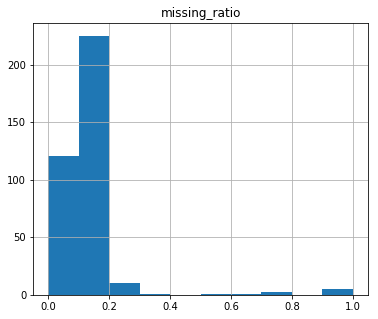

In [15]:
# See the distribution in order to decide the criterion
missing_eval.hist(figsize=(6,5))

It seemed that the missing ratio of most attributes are below 20%. Therefore, I will delete the outliers based on the criterion.

In [189]:
# Delete the outlier attributes that have more than 20% missing data ratio
attributes_outlier_list = missing_eval[missing_eval['missing_ratio'] >= 0.2]['feature']
azdias_cleaned = azdias_cleaned.drop(attributes_outlier_list, axis=1)

#### Evaluate missing data in each row

Text(0.5,1,'The missing value distribution')

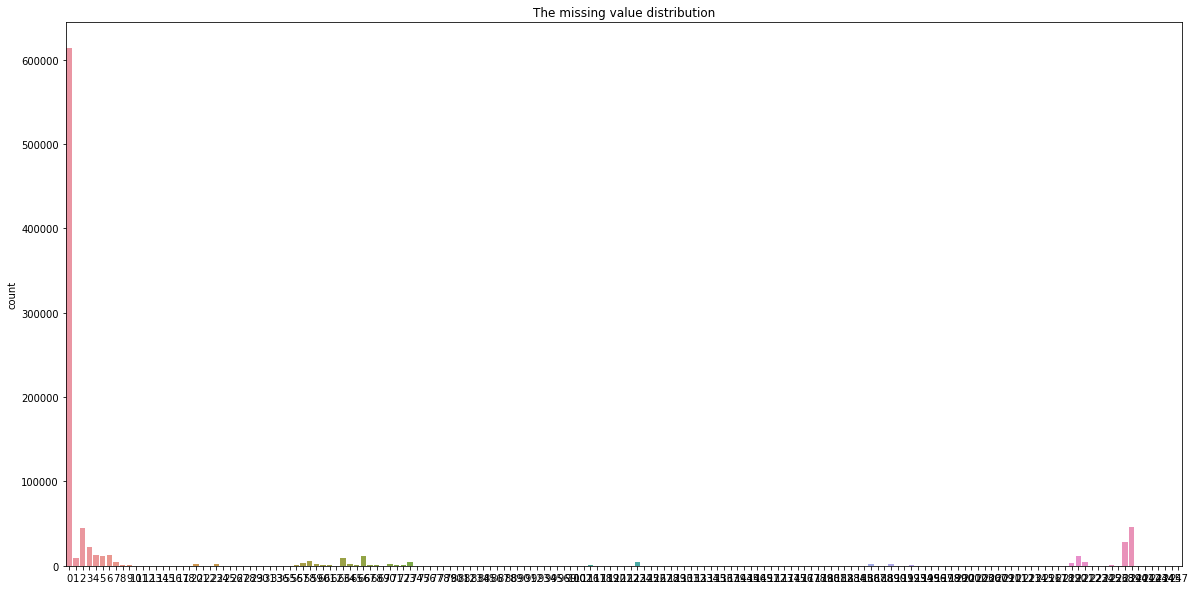

In [17]:
# How much data is missing in each row of the dataset?
plt.figure(figsize=(20, 10))
sns.countplot(len(azdias_cleaned.columns) - azdias_cleaned.count(axis=1))
plt.title('The missing value distribution')

Text(0,0.5,'number of rows')

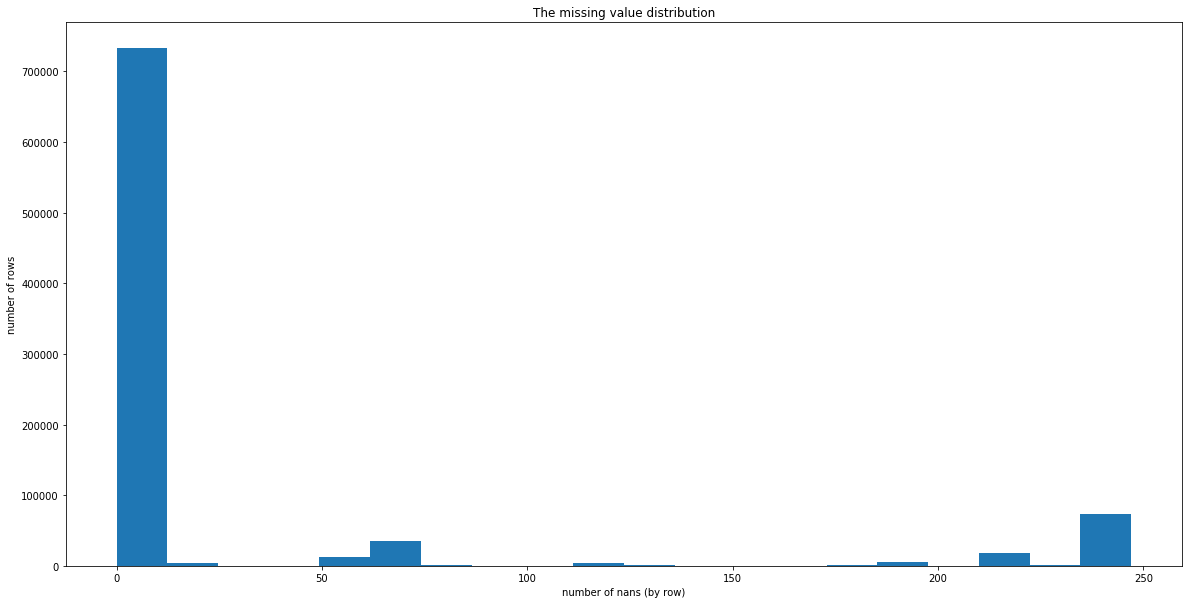

In [18]:
plt.figure(figsize=(20, 10))
plt.hist(len(azdias_cleaned.columns) - azdias_cleaned.count(axis=1), bins=20)
plt.title('The missing value distribution')
plt.xlabel('number of nans (by row)')
plt.ylabel('number of rows')

Based on the graph above, most rows have no missing value, so I will drop all the rows that have at least one missing value. However, in order to make sure the data I drop have no big inference to the whole data, I will check the distribution for some features.

In [190]:
azdias_nan_counts = len(azdias_cleaned.columns) - azdias_cleaned.count(axis=1)

In [191]:
criterion = 0 # criterion of number of missing values by row
azdias_informative = azdias_cleaned[azdias_nan_counts <= criterion]
azdias_noninformative = azdias_cleaned[azdias_nan_counts > criterion]

In [21]:
len(azdias_cleaned), len(azdias_informative) + len(azdias_noninformative), len(azdias_informative), len(azdias_noninformative), len(azdias_informative)/len(azdias_cleaned)

(891221, 891221, 613600, 277621, 0.688493650845301)

In [22]:
print('{:.2%} of data is left.'.format(len(azdias_informative)/len(azdias_cleaned)))

68.85% of data is left.


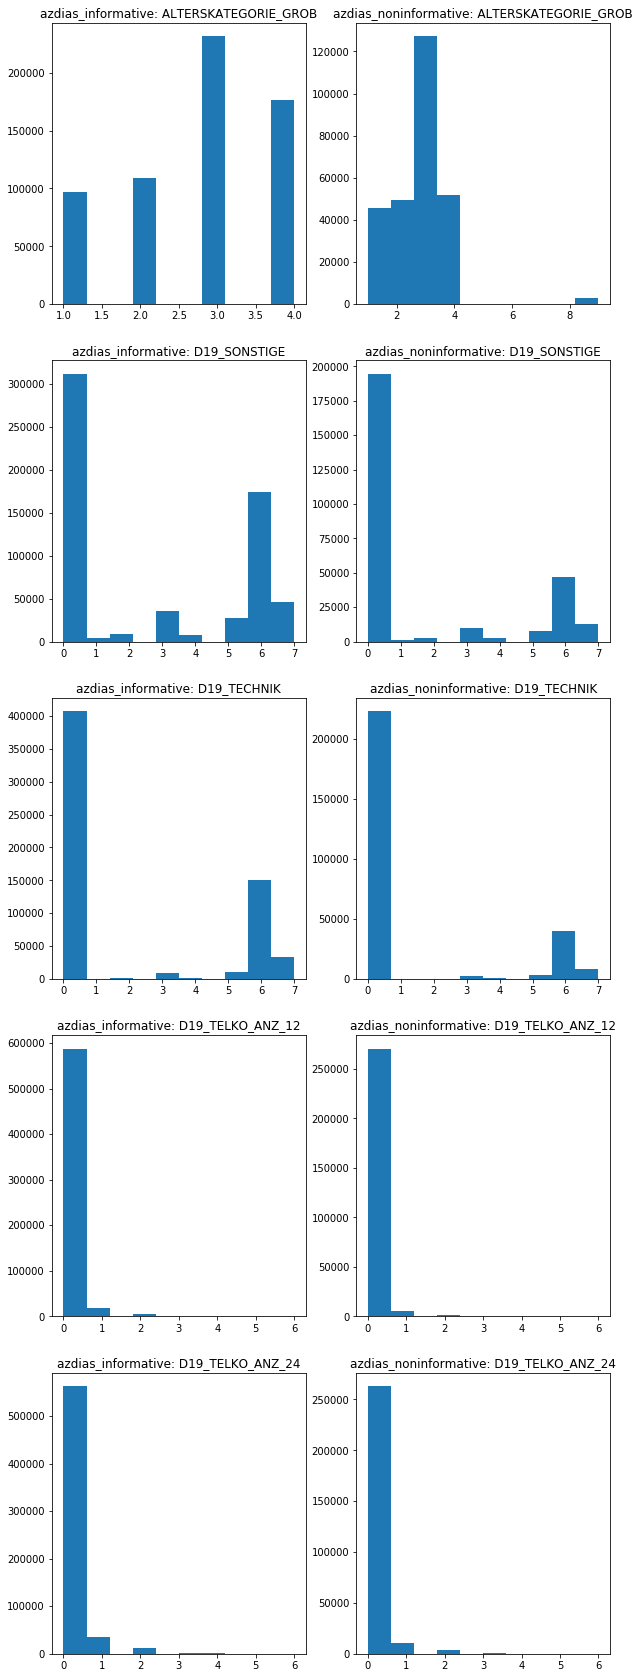

In [23]:
# Compare the distribution of values for at least five attributes between the two subsets.

# plot histgram with subplot
num_features = 5
num = 1
i = 1
plt.figure(figsize=(10, 30))

for index, row in missing_eval.iloc[::-1].iterrows():    
    plt.subplot(num_features, 2, num)
    title_wording = 'azdias_informative: ' + str(row['feature'])
    plt.title(title_wording)
    plt.hist(azdias_informative[row['feature']].dropna())
    
    plt.subplot(num_features, 2, num + 1)
    title_wording = 'azdias_noninformative: ' + str(row['feature'])
    plt.title(title_wording)
    plt.hist(azdias_noninformative[row['feature']].dropna())

    i += 1
    num += 2
    if i > num_features:
        break

(array([ 45908.,      0.,      0.,  49634.,      0.,      0., 127173.,
             0.,      0.,  52025.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

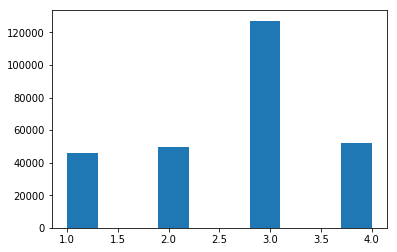

In [24]:
plt.hist(azdias_noninformative[azdias_noninformative['ALTERSKATEGORIE_GROB']<=4]['ALTERSKATEGORIE_GROB'].dropna())

Based on the graph above, the distribution of the deleted rows are not different from the rows left, so I will keep to drop all the rows that have at least one missing value.

### Re-Encode and pick up features

There are four types of data here:
1. ordinal
2. numeric
3. categorical
4. mixed

For ordinal variables, although the values might not be linearly related, I assume the ordinal variables as interval variables here. The remaining categorical and mixed variables will be re-encoded or picked up in this session.

#### Re-Encode Categorical Variables

In [192]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
categorical_feature_list = []
num_of_type_list = []

for feature in np.intersect1d(feature_summary[feature_summary['type'] == 'categorical']['Attribute'], azdias_informative.columns):
    print(feature)
    print(azdias_informative[feature].value_counts(), '\n')
    categorical_feature_list.append(feature)
    num_of_type_list.append(len(azdias_informative[feature].value_counts()))

categorical_feature = pd.DataFrame({'categorical_feature': categorical_feature_list, 'num_of_type': num_of_type_list})
categorical_feature = categorical_feature.merge(missing_eval, how='inner', left_on='categorical_feature', right_on='feature')
categorical_feature


ANREDE_KZ
2    314071
1    299529
Name: ANREDE_KZ, dtype: int64 

CAMEO_DEUG_2015
8      64797
6      49891
9      47917
8.0    46963
4      46148
3      36513
6.0    36442
9.0    34959
7      34880
2      34410
4.0    33702
3.0    26621
7.0    25503
2.0    24928
5      23736
5.0    16927
1      16851
1.0    12198
X      214  
Name: CAMEO_DEUG_2015, dtype: int64 

CAMEO_DEU_2015
6B    46216
8A    43567
4C    37821
3C    28903
2D    28089
7A    28016
8B    27014
8C    26484
3D    26403
4A    23892
9D    22209
9B    22144
9C    19223
7B    17966
9A    16524
8D    14695
6E    13709
2C    13552
5D    12105
6C    11914
2B    10781
1D    9493 
1A    8755 
5B    8063 
5C    7399 
5A    6982 
4D    6963 
2A    6916 
4B    6852 
7C    6848 
6A    5275 
6D    4893 
6F    4326 
4E    4322 
1E    4077 
3B    4029 
3A    3799 
7E    3791 
7D    3762 
1C    3416 
5F    3376 
1B    3308 
9E    2776 
5E    2738 
XX    214  
Name: CAMEO_DEU_2015, dtype: int64 

CJT_GESAMTTYP
4.0    158352
3.0    117268

,categorical_feature,num_of_type,feature,missing_ratio
0,ANREDE_KZ,2,ANREDE_KZ,0.000000
1,CAMEO_DEUG_2015,19,CAMEO_DEUG_2015,0.111060
2,CAMEO_DEU_2015,45,CAMEO_DEU_2015,0.111060
3,CJT_GESAMTTYP,6,CJT_GESAMTTYP,0.005446
4,FINANZTYP,6,FINANZTYP,0.000000
5,GEBAEUDETYP,7,GEBAEUDETYP,0.104517
6,GFK_URLAUBERTYP,12,GFK_URLAUBERTYP,0.005446
7,GREEN_AVANTGARDE,2,GREEN_AVANTGARDE,0.000000
8,HEALTH_TYP,3,HEALTH_TYP,0.124768
9,KBA05_HERSTTEMP,5,KBA05_HERSTTEMP,0.123468


In [193]:
# one binary variable that takes on non-numeric values: OST_WEST_KZ
# change it to numeric-binary

azdias_informative['OST_WEST_KZ'] = azdias_informative['OST_WEST_KZ'].map(lambda x: '0' if x == 'W' else '1')
azdias_informative['OST_WEST_KZ'].value_counts()

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    485361
1    128239
Name: OST_WEST_KZ, dtype: int64

In [194]:
# I just discovered that CAMEO_DEUG_2015 is not well encoded (float and integer are mixed)
# Will re-encoded it here
# The 'X' value is not written in the document, will replace it as nan

azdias_informative['CAMEO_DEUG_2015'] = azdias_informative['CAMEO_DEUG_2015'].map(lambda x: np.nan if x == 'X' else int(x))

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
# check
azdias_informative['CAMEO_DEUG_2015'].value_counts()

8.0    111760
6.0     86333
9.0     82876
4.0     79850
3.0     63134
7.0     60383
2.0     59338
5.0     40663
1.0     29049
Name: CAMEO_DEUG_2015, dtype: int64

In [195]:
# For those that are not binary categorical variables
non_binary_categorical_features = list(categorical_feature[categorical_feature['num_of_type'] > 2]['categorical_feature'])

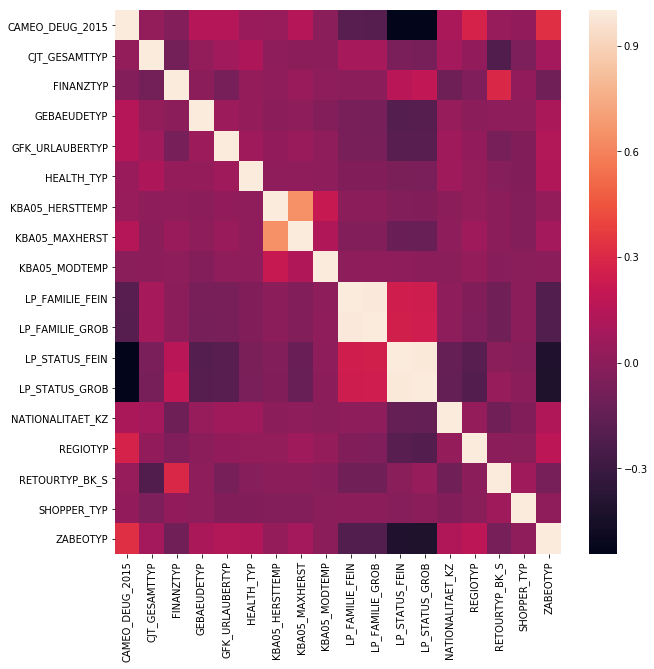

In [196]:
# Before using get_dummies() method, check the relationship between the categorical features.
sns.heatmap(azdias_informative[non_binary_categorical_features].corr())

Based on the graph above, `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` are highly correlated. `LP_STATUS_FEIN` and `LP_STATUS_GROB` are also highly correlated. Since `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` are too detailed, I will drop those two here. In addition, although `CAMEO_DEUG_2015`and `CAMEO_DEU_2015` are not plotted in the graph above, based on the description file both of them are very similar so I will drop `CAMEO_DEU_2015` to simplify that part. Finally, there is another object feature `EINGEFUEGT_AM` that is not described in the document, I will drop this one as well since I don't know the meaning of the variable.

In [197]:
# Separate the categorical features and then use get_dummies method
categorical_feature_sublist = list(set(categorical_feature_list) - set(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']))

azdias_informative_non_cat = azdias_informative[azdias_informative.columns[~azdias_informative.columns.isin(categorical_feature_list)]].drop(['EINGEFUEGT_AM'], axis=1)
azdias_informative_cat = azdias_informative[azdias_informative.columns[azdias_informative.columns.isin(categorical_feature_sublist)]]

In [198]:
azdias_informative_cat_dummy = pd.get_dummies(azdias_informative_cat.astype(str))

In [199]:
# combine the non-categorical columns and dummy columns
azdias_informative_dummy = pd.concat([azdias_informative_non_cat, azdias_informative_cat_dummy], axis=1)

In [34]:
# Check the results
azdias_informative_dummy.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 613600 entries, 1 to 891220
Data columns (total 425 columns):
LNR                            int64
AKT_DAT_KL                     float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_INTL_2015                object
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                      float64
CJT_TYP_5                      float64
CJT_TYP_6                      float64
D19_BANKEN_ANZ_12              int64
D19_BANKEN_ANZ_24              int64
D19_BANKEN_DATUM               int64
D19_BANKEN_DIREKT              int64
D19_BANKEN_GROSS               int64
D19_

#### Re-Encode Mixed Variables

Categorical variables is re-encoded and filtered, but there are still another topic here: mixed variables. The mixed variables compose values of more than two dimensions. I will look into the value and decide the re-coding method or drop part of them.

In [35]:
# Have a look of mixed variables
for feature in np.intersect1d(feature_summary[feature_summary['type'] == 'mixed']['Attribute'], azdias_informative_dummy.columns):
    print(feature)
    print(azdias_informative_dummy[feature].value_counts())
    print('missing_ratio: ' , missing_eval[missing_eval['feature'] == feature]['missing_ratio'],  '\n')
print(np.intersect1d(feature_summary[feature_summary['type'] == 'mixed']['Attribute'], azdias_informative_dummy.columns))

CAMEO_INTL_2015
51      62077
51.0    45066
24      42747
41      42232
24.0    30940
41.0    30764
14      28080
43      26687
54      21456
14.0    20285
43.0    19529
25      17672
54.0    15638
22      13701
25.0    13053
45      12677
13      11306
22.0    10191
55      10072
52       9546
45.0     9149
34       8621
23       8541
13.0     8230
15       7869
55.0     7399
31       7070
52.0     6978
44       6852
34.0     6222
23.0     6139
15.0     5701
31.0     5187
44.0     5062
35       4858
32       4718
33       4355
12       4006
35.0     3411
32.0     3345
33.0     3044
12.0     2910
XX        214
Name: CAMEO_INTL_2015, dtype: int64
missing_ratio:  19    0.11106
Name: missing_ratio, dtype: float64 

LP_LEBENSPHASE_FEIN
1.0     49201
5.0     45597
6.0     33950
2.0     32026
8.0     22661
29.0    22098
13.0    21930
7.0     21405
31.0    19894
11.0    18593
10.0    17917
30.0    17200
15.0    16883
12.0    16458
20.0    14693
3.0     14642
4.0     13923
14.0    13751
19.0  

In [200]:
# I just discovered that CAMEO_INTL_2015 is not well encoded (float and integer are mixed)
# Will re-encod it here
# The 'X' value is not written in the document, will replace it as nan

azdias_informative_dummy['CAMEO_INTL_2015'] = azdias_informative_dummy['CAMEO_INTL_2015'].map(lambda x: np.nan if x == 'XX' else int(x))

In [37]:
# check
azdias_informative_dummy['CAMEO_INTL_2015'].value_counts()

51.0    107143
24.0     73687
41.0     72996
14.0     48365
43.0     46216
54.0     37094
25.0     30725
22.0     23892
45.0     21826
13.0     19536
55.0     17471
52.0     16524
34.0     14843
23.0     14680
15.0     13570
31.0     12257
44.0     11914
35.0      8269
32.0      8063
33.0      7399
12.0      6916
Name: CAMEO_INTL_2015, dtype: int64

There are six mixed attributes in the azdias_informative_dummy dataframe.

1. CAMEO_INTL_2015
2. LP_LEBENSPHASE_FEIN
3. LP_LEBENSPHASE_GROB
4. PLZ8_BAUMAX
5. PRAEGENDE_JUGENDJAHRE
6. WOHNLAGE

Let us have a look for each attribute.

By looking into CAMEO_INTL_2015 attribute, it seem the attribute can be separated into two interval variables: one is related to wealth and the  other one is related to lifestage.

In [201]:
# mixed: CAMEO_INTL_2015: separate into to interval variables:
azdias_informative_dummy['CAMEO_INTL_2015_WEALTH'] =  azdias_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[0]) if not np.isnan(x) else x)
azdias_informative_dummy['CAMEO_INTL_2015_LIFESTAGE'] =  azdias_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[1]) if not np.isnan(x) else x)
azdias_informative_dummy = azdias_informative_dummy.drop('CAMEO_INTL_2015', axis=1)
azdias_informative_dummy

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KB

Regarding LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, since both of them describe the life stage of a person which shares similar traits to CAMEO_INTL_2015, I will drop the two attributes here. On the other hand, the PLZ8_BAUMAX and WOHNLAGE attributes can be regarded as interval variables to some extent, I will preserve them here. Finally, I will look into PRAEGENDE_JUGENDJAHRE attribute.

By looking in to PRAEGENDE_JUGENDJAHRE feature, it can also be separated into two parts: decades and movement. Therefore I will create two functions to deal with this varaible.

In [202]:
def decade_PRAEGENDE_JUGENDJAHRE(int_num):
    '''
    Based on the attribute description file, change the value in PRAEGENDE_JUGENDJAHRE to decade meaning.
    
    INPUT: integer
    OUTPUT: integer (4 means 40ies, 5 means 50ies, ...)
    
    '''
    if int_num in (1, 2):
        return 4
    elif int_num in (3, 4):
        return 5
    elif int_num in (5, 6, 7):
        return 6
    elif int_num in (8, 9):
        return 7
    elif int_num in (10, 11, 12, 13):
        return 8
    elif int_num in (14, 15):
        return 9
    else:
        return 0

In [203]:
def movement_PRAEGENDE_JUGENDJAHRE(int_num):
    '''
    Based on the attribute description file, change the value in PRAEGENDE_JUGENDJAHRE to movement meaning.
    
    INPUT: integer
    OUTPUT: integer (1 means Mainstream, 2 means Avantgarde)
    
    '''
    if int_num in (1, 3, 5, 8, 10, 12,14):
        return 1
    elif int_num in (2, 4, 6, 7, 9, 11, 13, 15):
        return 2
    else:
        return 0

In [204]:
# PRAEGENDE_JUGENDJAHRE
azdias_informative_dummy['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_informative_dummy['PRAEGENDE_JUGENDJAHRE'].map(lambda x: decade_PRAEGENDE_JUGENDJAHRE(x))
azdias_informative_dummy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_informative_dummy['PRAEGENDE_JUGENDJAHRE'].map(lambda x: movement_PRAEGENDE_JUGENDJAHRE(x))
azdias_informative_dummy.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
azdias_informative_dummy

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KB

In [205]:
# Drop the other two mixed columns mentioned.
azdias_informative_dummy = azdias_informative_dummy.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1) 

### Create a Cleaning Function

SInce all the dataframe will be cleaned, recoded, filtered through the same process, I will create a cleaning function to simplify all the process.

In [206]:
def clean_data(df, attributes_outlier_list):
    '''
    Perform feature trimming, re-encoding, and engineering for demographics data.
    
    INPUT: 
    df: Demographics DataFrame
    attributes_outlier_list: In order to preserve the same filtered column list across different data set, 
                                            the outlier list created in pre-processing of general population data will be delivered.
    
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''
    
    # Read the depcription file
    feature_summary = pd.read_csv('DIAS_Attributes_Values_2017_details.csv')
    
    
    ############         Deal with missing/unknown value            ############
    def nan_list_func(attribute_name):
        '''
        Get the missing_or_unknown value list from feature_summary.

        <INPUT>
        attribute_name: attribute name in feature_summary    

        <OUTPUT>
        missing_value_list:  the string value list that should be substituted as np.nan

        '''
        missing_str = str(feature_summary[feature_summary['Attribute'] == attribute_name]['missing_or_unknown'].iloc[0]).replace(' ', '')
        missing_value_list = missing_str.split(',')   
        
        return missing_value_list


    def int_float_fix(obj):
        '''
        Purpose: for an object that is float type, return the string integer to assure the substituting process works well.
        For the other types, return the string type. (nan is remain as nan)
        Ex: 
        3.0 -> '3'
        5.0 -> '5'
        nan -> nan
        'XX' -> 'XX'
        2 -> '2'

        <INPUT>
        objects with the following types: int, float, str

        <OUTPUT>
        str object

        '''
        if type(obj) == str or pd.isnull(obj):
            return obj
        else:
            return str(int(obj))
    
    
    
    # Substitute the missing/unknown encodings to Nans
    main_df = df.copy()  # deep copy
    intersection_attributes = np.intersect1d(feature_summary['Attribute'],main_df.columns) # The attributes should be processed
    
    for column in intersection_attributes:
        missing_value_list = nan_list_func(column)
        main_df[column] = main_df[column].map(lambda x: np.nan if int_float_fix(x) in missing_value_list else x)

    
    
    
    # Perform an assessment of how much missing data there is in each column of the dataset.
    missing_evaluation = []
    len_main = main_df.shape[0]

    for column in main_df.columns:
        missing_ratio = 1-  (main_df[column].count() / len_main) # cannnot use np.isnan here, since TypeError happens.
        missing_evaluation.append(missing_ratio)
    missing_eval = pd.DataFrame(data={'feature': main_df.columns, 
                                                               'missing_ratio': missing_evaluation}).sort_values(by='missing_ratio', ascending=False)

    
    
    
    # (Ignored here) Delete the outlier attributes that have more than 20% missing data ratio
    # (Ignored here)  attributes_outlier_list = missing_eval[missing_eval['missing_ratio'] >= 0.2]['feature']
    main_cleaned = main_df.drop(attributes_outlier_list, axis=1)
    
    
    
    
    # Deal with rows
    main_nan_counts = len(main_cleaned.columns) - main_cleaned.count(axis=1)
    criterion = 0 # criterion of number of missing values by row
    main_informative = main_cleaned[main_nan_counts <= criterion]
    main_noninformative = main_cleaned[main_nan_counts > criterion]
    
    
    
    
    # Re-encode categorical/mixed attributes
    # Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
    categorical_feature_list = []
    num_of_type_list = []

    for feature in np.intersect1d(feature_summary[feature_summary['type'] == 'categorical']['Attribute'], main_informative.columns):
        categorical_feature_list.append(feature)
        num_of_type_list.append(len(main_informative[feature].value_counts()))

    categorical_feature = pd.DataFrame({'categorical_feature': categorical_feature_list, 'num_of_type': num_of_type_list})
    categorical_feature = categorical_feature.merge(missing_eval, how='inner', left_on='categorical_feature', right_on='feature')

    
    # one binary variable that takes on non-numeric values: OST_WEST_KZ 
    # change it to numeric-binary
    main_informative['OST_WEST_KZ'] = main_informative['OST_WEST_KZ'].map(lambda x: '0' if x == 'W' else '1')

    
    # CAMEO_DEUG_2015 is not well encoded (float and integer are mixed)
    # Will re-encoded it here
    # The 'X' value is not written in the document, will replace it as nan
    main_informative['CAMEO_DEUG_2015'] = main_informative['CAMEO_DEUG_2015'].map(lambda x: np.nan if x == 'X' else int(x))
    


    # Separate the categorical features and then use get_dummies method
    categorical_feature_sublist = list(set(categorical_feature_list) - set(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']))
    main_informative_non_cat = main_informative[main_informative.columns[~main_informative.columns.isin(categorical_feature_list)]].drop(['EINGEFUEGT_AM'], axis=1)
    main_informative_cat = main_informative[main_informative.columns[main_informative.columns.isin(categorical_feature_sublist)]]
    
    main_informative_cat_dummy = pd.get_dummies(main_informative_cat.astype(str))
    
    # combine the non-categorical columns and dummy columns
    main_informative_dummy = pd.concat([main_informative_non_cat, main_informative_cat_dummy], axis=1)
    
    
    
    # CAMEO_INTL_2015 is not well encoded (float and integer are mixed)
    # Will re-encod it here
    # The 'X' value is not written in the document, will replace it as nan
    main_informative_dummy['CAMEO_INTL_2015'] = main_informative_dummy['CAMEO_INTL_2015'].map(lambda x: np.nan if x == 'XX' else int(x))
    
    
    
    # mixed: CAMEO_INTL_2015: separate into to interval variables:
    main_informative_dummy['CAMEO_INTL_2015_WEALTH'] =  main_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[0]) if not np.isnan(x) else x)
    main_informative_dummy['CAMEO_INTL_2015_LIFESTAGE'] =  main_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[1]) if not np.isnan(x) else x)
    main_informative_dummy = main_informative_dummy.drop('CAMEO_INTL_2015', axis=1)

    
    
    def decade_PRAEGENDE_JUGENDJAHRE(int_num):
        '''
        Based on the attribute description file, change the value in PRAEGENDE_JUGENDJAHRE to decade meaning.

        INPUT: integer
        OUTPUT: integer (4 means 40ies, 5 means 50ies, ...)

        '''
        if int_num in (1, 2):
            return 4
        elif int_num in (3, 4):
            return 5
        elif int_num in (5, 6, 7):
            return 6
        elif int_num in (8, 9):
            return 7
        elif int_num in (10, 11, 12, 13):
            return 8
        elif int_num in (14, 15):
            return 9
        else:
            return 0
    
    
    
    def movement_PRAEGENDE_JUGENDJAHRE(int_num):
        '''
        Based on the attribute description file, change the value in PRAEGENDE_JUGENDJAHRE to movement meaning.

        INPUT: integer
        OUTPUT: integer (1 means Mainstream, 2 means Avantgarde)

        '''
        if int_num in (1, 3, 5, 8, 10, 12,14):
            return 1
        elif int_num in (2, 4, 6, 7, 9, 11, 13, 15):
            return 2
        else:
            return 0
    
    # mixed: PRAEGENDE_JUGENDJAHRE
    main_informative_dummy['PRAEGENDE_JUGENDJAHRE_DECADE'] = main_informative_dummy['PRAEGENDE_JUGENDJAHRE'].map(lambda x: decade_PRAEGENDE_JUGENDJAHRE(x))
    main_informative_dummy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = main_informative_dummy['PRAEGENDE_JUGENDJAHRE'].map(lambda x: movement_PRAEGENDE_JUGENDJAHRE(x))
    main_informative_dummy.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    
    # Drop the other two mixed columns mentioned.
    main_informative_dummy = main_informative_dummy.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1)     
    
    return main_informative_dummy

In [46]:
check_dataframe = clean_data(azdias, attributes_outlier_list)

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel/__main__.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel/__main__.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
check_dataframe.equals(azdias_informative_dummy)

True

### Remaining Nans and Scaling

In [207]:
# deal with remaining Nans
azdias_informative_dummy = azdias_informative_dummy.drop(['LNR'], axis=1)
my_imputer = Imputer(strategy='mean', axis=0, copy=True)
azdias_informative_dummy_nonan = pd.DataFrame(data=my_imputer.fit_transform(azdias_informative_dummy),columns=azdias_informative_dummy.columns)


# Apply feature scaling to the general population demographics data.
scale = StandardScaler()
azdias_informative_dummy_nonan_scaled = pd.DataFrame(data=scale.fit_transform(azdias_informative_dummy_nonan), columns=azdias_informative_dummy_nonan.columns)

In [383]:
azdias_informative_dummy_nonan_scaled.shape

(613600, 425)

In [208]:
# check the missing value in azdias_informative_dummy
missing_evaluation_2 = []

for column in azdias_informative_dummy_nonan_scaled.columns:
    missing_ratio = (len(azdias_informative_dummy_nonan_scaled[column]) - azdias_informative_dummy_nonan_scaled[column].count()) / len(azdias_informative_dummy_nonan_scaled[column])
    missing_evaluation_2.append(missing_ratio)

missing_eval_2 = pd.DataFrame(data={'feature': azdias_informative_dummy_nonan_scaled.columns, 
                     'missing_ratio': missing_evaluation_2}).sort_values(by='missing_ratio', ascending=False)
missing_eval_2


,feature,missing_ratio
0,AKT_DAT_KL,0.0
292,SEMIO_KRIT,0.0
290,SEMIO_FAM,0.0
289,SEMIO_ERL,0.0
288,SEMIO_DOM,0.0
287,RT_UEBERGROESSE,0.0
286,RT_SCHNAEPPCHEN,0.0
285,RT_KEIN_ANREIZ,0.0
284,RELAT_AB,0.0
283,PRAEGENDE_JUGENDJAHRE,0.0


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Since there are hundreds of features here, it is better to use Principle Components Method to capture the main contribution to the main factors. I will conduct the 

In [209]:
# Apply PCA 
pca = PCA()
pca.fit(X=azdias_informative_dummy_nonan_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'accumulated_explained_variance_ratio')

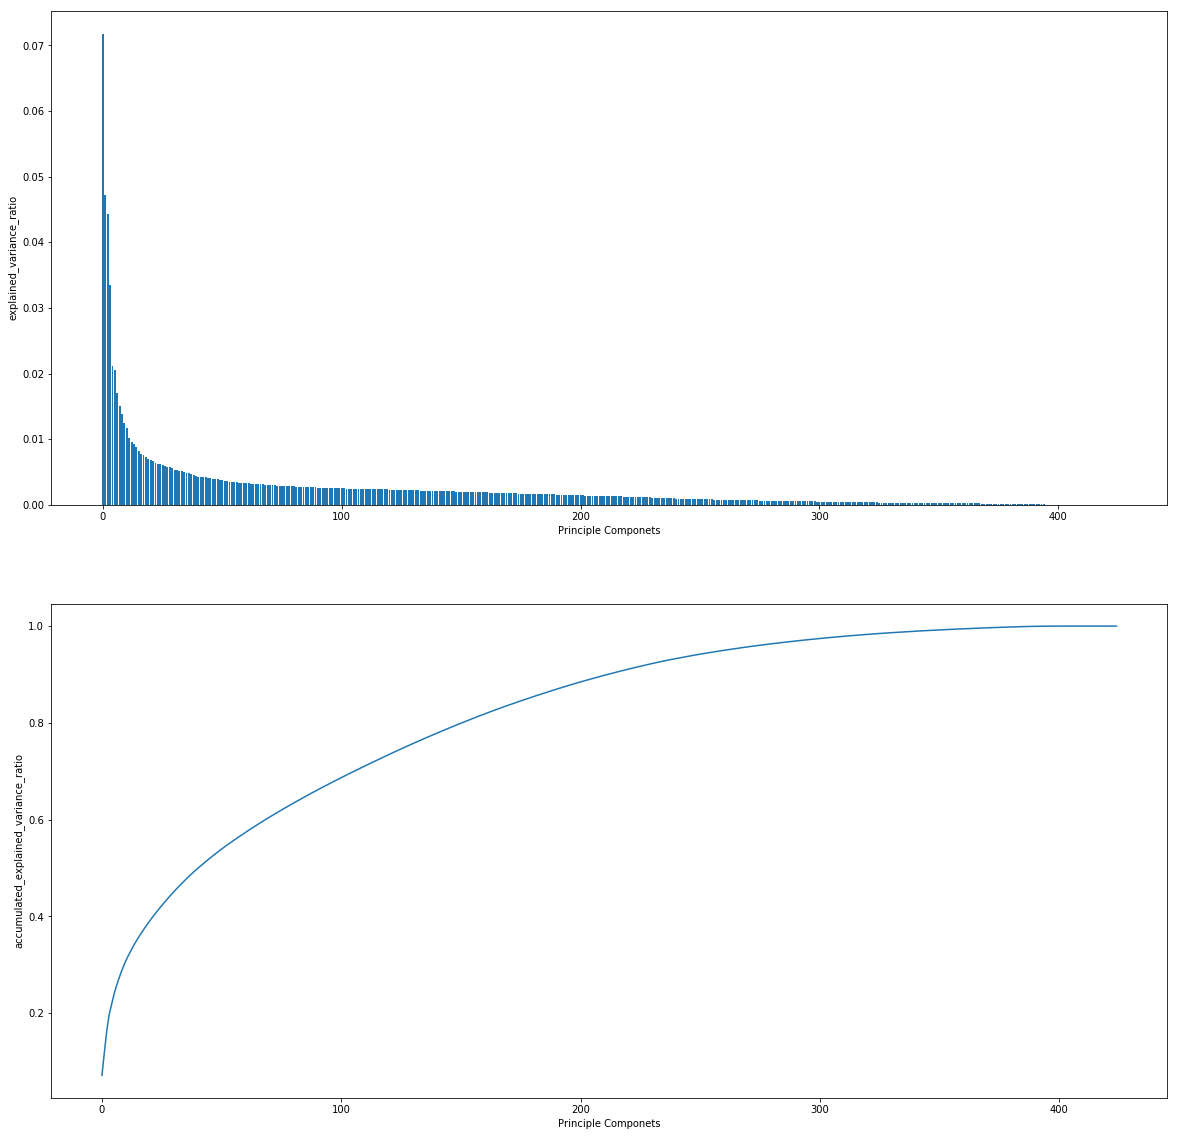

In [210]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.bar(list(range(len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('Principle Componets')
plt.ylabel('explained_variance_ratio')

plt.subplot(2,1,2)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Principle Componets')
plt.ylabel('accumulated_explained_variance_ratio')

Text(0,0.5,'explained_variance_ratio')

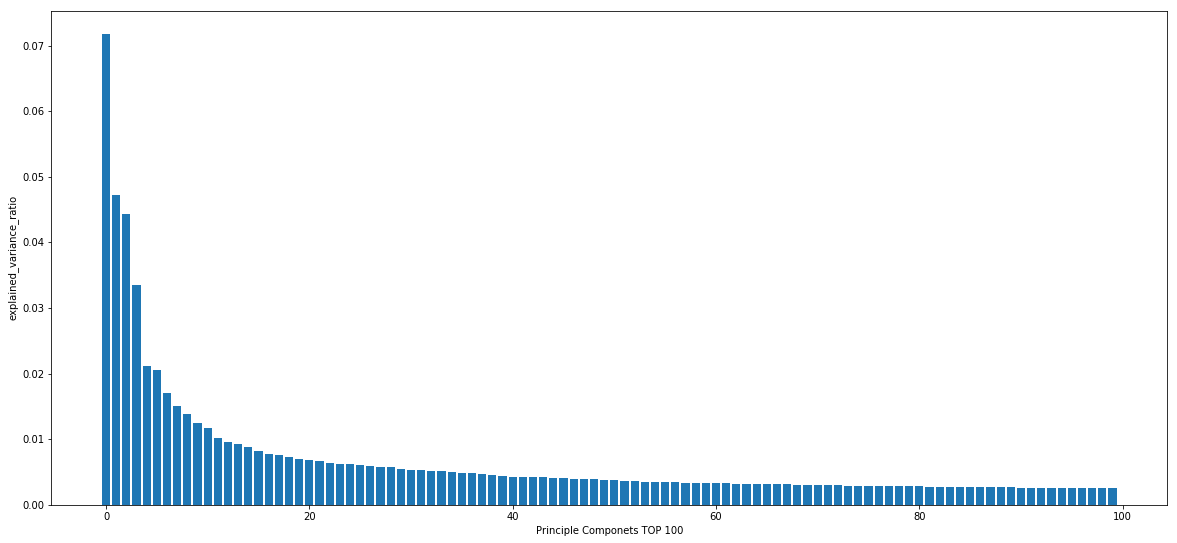

In [211]:
# Zoom in (TOP 100)

plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.bar(list(range(len(pca.explained_variance_ratio_)))[:100], pca.explained_variance_ratio_[:100])
plt.xlabel('Principle Componets TOP 100')
plt.ylabel('explained_variance_ratio')

It looks like that the first 6 componets have the most explained variance, after 6th componets, the accumulated variance increases slowly. In the following parts, I will look into the 6 main components.

In [212]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_decided = PCA(n_components=6)
pca_decided.fit(X=azdias_informative_dummy_nonan_scaled)

# create well-prepared dataframe in order to sort value
main6comps = pd.DataFrame({'features': azdias_informative_dummy_nonan_scaled.columns,
              'comp1': pca_decided.components_.transpose()[:,0],
              'comp2': pca_decided.components_.transpose()[:,1],
              'comp3': pca_decided.components_.transpose()[:,2],
              'comp4': pca_decided.components_.transpose()[:,3],
              'comp5': pca_decided.components_.transpose()[:,4],
              'comp6': pca_decided.components_.transpose()[:,5]})

main6comps.sort_values(by='comp1', ascending=False)

# define a function to print easily
def get_feature_orders_by_componet(componet_number):
    component = eval("'comp' + cp", {'cp': str(componet_number)})
    sorted_result = main6comps.sort_values(by=component, ascending=False)
    return sorted_result[[component, 'features']]

In [213]:
# Show the fisr 10 features and description per componet
pd.set_option('display.max_colwidth', -1)
for i in range(1, 7):
    display(pd.merge(get_feature_orders_by_componet(i).head(10), feature_summary, left_on='features', right_on='Attribute').iloc[:, [0,1,3]])

,comp1,features,Description
0,0.138715,MOBI_REGIO,moving patterns
1,0.133602,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8
2,0.130201,KBA05_ANTG1,number of 1-2 family houses in the cell
3,0.123796,KBA05_AUTOQUOT,share of cars per household
4,0.121753,KBA05_GBZ,number of buildings in the microcell
5,0.117655,KBA13_AUTOQUOTE,share of cars per household within the PLZ8
6,0.113094,FINANZ_MINIMALIST,financial typology: low financial interest


,comp2,features,Description
0,0.182232,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream)
1,0.170895,FINANZ_SPARER,financial typology: money saver
2,0.153695,ONLINE_AFFINITAET,online affinity
3,0.151125,FINANZ_ANLEGER,financial typology: investor
4,0.147242,SEMIO_PFLICHT,affinity indicating in what way the person is dutyfull traditional minded
5,0.142719,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable
6,0.136685,SEMIO_TRADV,affinity indicating in what way the person is traditional minded


,comp3,features,Description
0,0.175989,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8
1,0.152206,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)"
2,0.149849,KBA13_MERCEDES,share of MERCEDES within the PLZ8
3,0.147312,KBA13_BMW,share of BMW within the PLZ8
4,0.143498,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8
5,0.136842,KBA13_SEG_SPORTWAGEN,share of sportscars within the PLZ8
6,0.125274,KBA05_HERST1,"share of top German manufacturer (Mercedes, BMW)"
7,0.120078,KBA13_KMH_211,share of cars with a greater max speed than 210 km/h within the PLZ8
8,0.118419,KBA13_SEG_OBERKLASSE,share of upper class cars (BMW 7er etc.) in the PLZ8
9,0.118333,KBA13_KW_121,share of cars with an engine power more than 120 KW - PLZ8


,comp4,features,Description
0,0.149453,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24 months
1,0.140358,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12 months
2,0.139763,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24 months
3,0.128949,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12 months
4,0.101130,ORTSGR_KLS9,size of the community
5,0.100796,EWDICHTE,density of inhabitants per square kilometer
6,0.097483,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8


,comp5,features,Description
0,0.160350,KBA13_KW_61_120,share of cars with an engine power between 61 and 120 KW - PLZ8
1,0.141662,KBA13_VORB_0,share of cars with no preowner - PLZ8
2,0.135586,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8
3,0.104164,KBA13_HERST_ASIEN,share of Asian Manufacturers within the PLZ8
4,0.101481,KBA05_VORB0,share of cars with no preowner
5,0.100810,KBA13_KRSZUL_NEU,share of newbuilt cars (referred to the county average) - PLZ8
6,0.099065,KBA13_HALTER_25,share of car owners between 21 and 25 within the PLZ8


,comp6,features,Description
0,0.281326,SEMIO_VERT,affinity indicating in what way the person is dreamily
1,0.246574,SEMIO_FAM,affinity indicating in what way the person is familiar minded
2,0.242788,SEMIO_KULT,affinity indicating in what way the person is cultural minded
3,0.227299,SEMIO_SOZ,affinity indicating in what way the person is social minded
4,0.136722,SEMIO_REL,affinity indicating in what way the person is religious


### Discussion of principal componets

Here is the summary based on the details of each component.
I will call PCA component 1 as `Rich People Index` since it has the following features: 
low mobility (moving patterns), high share of 1-2 family houses in the PLZ8, high share of cars per household, lots buildings in the microcell and high financial interest. It might be some people that care about financial news or products, and living in a busy city area and tend not to live alone or with partner.


PCA component 2 as `Young and Wandering Index` which has the following characteristics:
The person's youth is mainly in 90ies with digital media, not a money saver, has high online affinity, not a financial investor,  not traditional minded.

PCA compoent 3 as `Car Brand Mania Index`: high share of BMW & Mercedes Benz, upper class cars or sportscars, high share of top German manufacturer (Mercedes, BMW)


PCA compoent 4 as `Online Shopper Index`: high transaction activity, high transaction activity MAIL-ORDER, high density of inhabitants per square kilometer, large number of 6-10 family houses


PCA compoent 5 as `Car Life Index`:  high share of cars with an engine power between 61 and 120 KW, high share of cars with no preowner, 
large number of cars with 5 seats, high share of Asian Manufacturers, high share of newbuilt cars


PCA compoent 6 as `Anti-society Index`: low dreamily affinity, low familiar minded, low cultural and social minded, not religious



### Clustering

By using the main 6 PCA compnents above, I will use KMeans to apply clusterings to general population.

#### General Population

elapsed_time: 96.6903663357099 minutes.


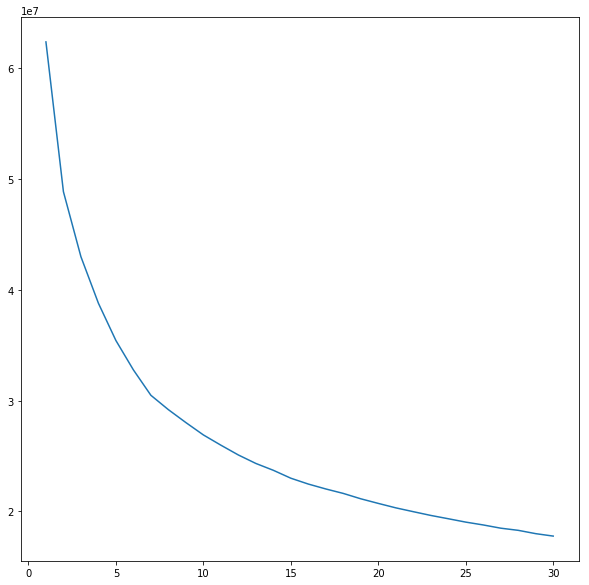

In [95]:
# Use Kmeans to apply clustering
pca_transformed = pca_decided.transform(azdias_informative_dummy_nonan_scaled)


start = time.time()

# Over a number of different cluster counts...
k_list = []
score_list = []

for k in range(1,31):
    # run k-means clustering on the data and...
    kmeans = KMeans(k)
    model = kmeans.fit(pca_transformed)

    # compute the average within-cluster distances.
    score = model.score(pca_transformed)
    k_list.append(k)
    score_list.append(abs(score))     
    
elapsed_time = time.time() - start
print ("elapsed_time: {0}".format(elapsed_time/60) + " minutes.")    

# Investigate the change in within-cluster distance across number of clusters.
# Plot
plt.plot(k_list, score_list)

Text(0.5,1,'The change of score to k')

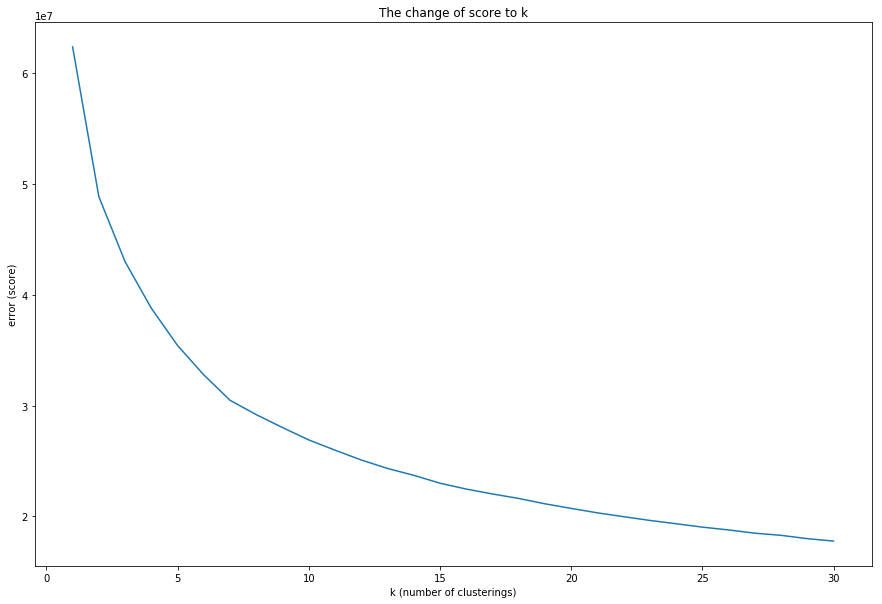

In [387]:
# Plot with labels
plt.figure(figsize=(15,10))
plt.plot(k_list, score_list)
plt.xlabel('k (number of clusterings)')
plt.ylabel('error (score)')
plt.title('The change of score to k')

In [214]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data.

start = time.time()

# k = 30
kmeans = KMeans(30)
kmeans_model = kmeans.fit(pca_transformed)  

elapsed_time = time.time() - start
print ("elapsed_time: {0}".format(elapsed_time/60) + " minutes.")    

elapsed_time: 9.904375632603964 minutes.


In [215]:
# Get the clusters of general population
general_population_clusters = kmeans_model.predict(pca_transformed)
general_population_clusters

array([16, 16, 22, ..., 23, 20, 21], dtype=int32)

#### Customer Data

In [216]:
# Assure the input columns are the same
customers_sub = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

In [217]:
# Apply all the pre-processing process and scaling to customer data
start = time.time()

# Pre-Processing
customers_informative_dummy = clean_data(customers_sub, attributes_outlier_list)
customers_informative_dummy = customers_informative_dummy.drop(['LNR'], axis=1)

# deal with remaining Nans
customers_informative_dummy_nonan = pd.DataFrame(data=my_imputer.fit_transform(customers_informative_dummy),columns=customers_informative_dummy.columns)

# Apply feature scaling to the general population demographics data.
customers_informative_dummy_nonan_scaled = pd.DataFrame(data=scale.fit_transform(customers_informative_dummy_nonan), columns=customers_informative_dummy_nonan.columns)


# In the get_dummies method, for some values that are not included in the final results, create them with 0 values
if 'GEBAEUDETYP_5.0' not in set(customers_informative_dummy_nonan_scaled.columns):
    customers_informative_dummy_nonan_scaled['GEBAEUDETYP_5.0'] = 0

    
# PCA & KMeans
print('** PCA  & KMeans prediction **')
customers_pca_transformed = pca_decided.transform(customers_informative_dummy_nonan_scaled)
customers_clusters = kmeans_model.predict(customers_pca_transformed)

elapsed_time = time.time() - start
print ("elapsed_time: {0}".format(elapsed_time/60) + " minutes.")  

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel/__main__.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel/__main__.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


** PCA  & KMeans prediction **
elapsed_time: 1.0976036310195922 minutes.


### Compare Customer Data to General Population Data

Text(0.5,1,'customer_population_clusters')

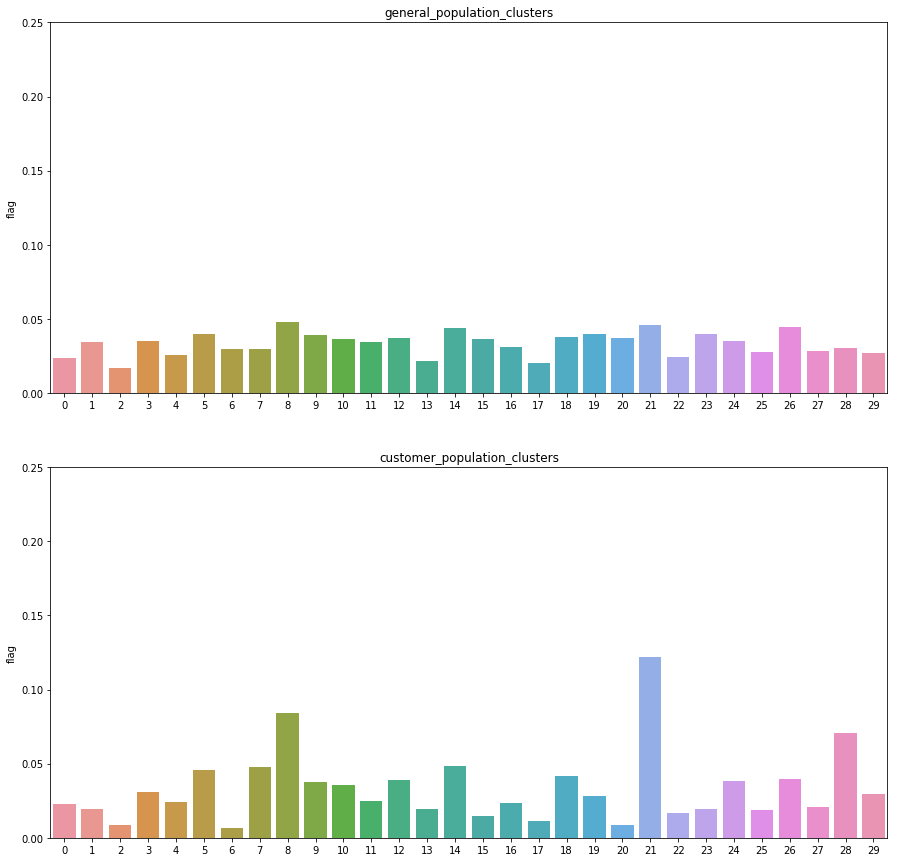

In [218]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

gp_clusters_df = pd.DataFrame(data=general_population_clusters, columns=['flag'])['flag'].value_counts()/len(general_population_clusters)
cs_clusters_df = pd.DataFrame(data=customers_clusters, columns=['flag'])['flag'].value_counts()/len(customers_clusters)

plt.figure(figsize=(15,15))010

plt.subplot(2,1,1)
sns.barplot(x=gp_clusters_df.index, y=gp_clusters_df)
plt.ylim(0, 0.25)
plt.title('general_population_clusters')

plt.subplot(2,1,2)
sns.barplot(x=cs_clusters_df.index, y=cs_clusters_df)
plt.ylim(0, 0.25)
plt.title('customer_population_clusters')

In [219]:
# Compare the cluster distribution between general population and customers
gp_cs_compare = pd.concat([gp_clusters_df, cs_clusters_df], axis=1,  join='inner')
gp_cs_compare.columns=['gp_portion', 'cs_portion']
gp_cs_compare['portion_diff'] = gp_cs_compare.cs_portion - gp_cs_compare.gp_portion
gp_cs_compare.sort_values(by='portion_diff', ascending=False)

,gp_portion,cs_portion,portion_diff
21,0.045851,0.122258,0.076407
28,0.030427,0.070681,0.040254
8,0.047591,0.084014,0.036423
7,0.029438,0.047570,0.018132
5,0.039920,0.045484,0.005564
14,0.043713,0.048448,0.004735
18,0.037924,0.041903,0.003979
24,0.035024,0.038313,0.003289
29,0.027220,0.029795,0.002576
12,0.036863,0.038661,0.001798


Memo: 
CS > G : 21, 28
G < CS : 6, 20

In [226]:
# What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

# cluster 21, 28
print(kmeans_model.cluster_centers_[21,:])
print(kmeans_model.cluster_centers_[28,:])

[-1.04656724 -3.93220586  0.37061485 -1.25110104 -0.59786994  2.44613227]
[-0.18001649 -0.28172606 -0.59939528  5.09291245 -2.62365387 -0.39157115]


In [227]:
# What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

# cluster 6, 20
print(kmeans_model.cluster_centers_[6,:])
print(kmeans_model.cluster_centers_[20,:])

[-8.85795468  2.30305422 -3.99277944  0.26172556  4.34712078  0.41420879]
[-7.47172113  2.69427908  1.16650913 -1.95385055 -0.56005045  3.66263592]


General population that are more likely to be part of the mail-order company's main customer: cluster 21 and 28
General population that are less likely to be part of the mail-order company's main customer: cluster 6 and 20

Looking into each clusters, here is the characteristic for each (take the criterion of absolute value of 3 for convenience):
cluster 21: PCA component 2 (Young and Wandering Index) is negatively related.
cluster 28: PCA component 4 (Online Shopper Index) is positively related.
cluster 6: PCA component 1 (Rich People Index) and 3 (Car Brand Mania Index) are negatively related while PCA component 5 (Car Life Index) is positively related
cluster 20: PCA component 1 (Rich People Index) is negatively related while 6  (Anti-society Index) are positively related

Combining all the information above, here is the summary.
The population tend to be customer: The people who may be adults and usually shop online.
The population might not be customer: The people who are not rich, nor focusing on the brand of cars. However, they tend to use cars often. Some of them might have some anti-society characteristics.

To sum up, the target of the campaign should focus the users who are not young and use e-shopping often. On the other hand, for those very rich or interested to cars a lot or have anti-society traits, there might be no need to send the campaign to them.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Data pre-processing and PCA/Kmeans clustering

In [222]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv')
del mailout_train['Unnamed: 0']

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [13]:
mailout_train.shape

(42962, 367)

In Udacity_MAILOUT_052018_TRAIN data, there is an additional column called `RESPONSE`. Since the pre-processing and scaling all used the features that does not include RESPONSE column, I will separate it to another dataframe to complete the pre-processing part. After the pre-processing parts, I will join the `RESPONSE` to the cleaned data by users (LNR). 

I will use the PCA and KMeans method to get the clusterings for each user, and I will use the clustering information and PCA componets to predict the RESPONSE value.

In [157]:
# have a look of the Train data
mailout_train['RESPONSE'].value_counts()

0    42430
1    532  
Name: RESPONSE, dtype: int64

In [300]:
# separate the data into two parts
mailout_train_to_be_cleaned = mailout_train.drop(['RESPONSE'], axis=1)
mailout_train_response = mailout_train['RESPONSE']

Pre-processing and PCA/KMeans Process of the MAILOUT Train data. In order to preserve all the rows to predict, I will revise the clean function a little bit.

In [254]:
def clean_data_preserve_row(df, attributes_outlier_list):
    '''
    Perform feature trimming, re-encoding, and engineering for demographics data.
    
    INPUT: 
    df: Demographics DataFrame
    attributes_outlier_list: In order to preserve the same filtered column list across different data set, 
                                            the outlier list created in pre-processing of general population data will be delivered.
    
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''
    
    # Read the depcription file
    feature_summary = pd.read_csv('DIAS_Attributes_Values_2017_details.csv')
    
    
    ############         Deal with missing/unknown value            ############
    def nan_list_func(attribute_name):
        '''
        Get the missing_or_unknown value list from feature_summary.

        <INPUT>
        attribute_name: attribute name in feature_summary    

        <OUTPUT>
        missing_value_list:  the string value list that should be substituted as np.nan

        '''
        missing_str = str(feature_summary[feature_summary['Attribute'] == attribute_name]['missing_or_unknown'].iloc[0]).replace(' ', '')
        missing_value_list = missing_str.split(',')   
        
        return missing_value_list


    def int_float_fix(obj):
        '''
        Purpose: for an object that is float type, return the string integer to assure the substituting process works well.
        For the other types, return the string type. (nan is remain as nan)
        Ex: 
        3.0 -> '3'
        5.0 -> '5'
        nan -> nan
        'XX' -> 'XX'
        2 -> '2'

        <INPUT>
        objects with the following types: int, float, str

        <OUTPUT>
        str object

        '''
        if type(obj) == str or pd.isnull(obj):
            return obj
        else:
            return str(int(obj))
    
    
    
    # Substitute the missing/unknown encodings to Nans
    main_df = df.copy()  # deep copy
    intersection_attributes = np.intersect1d(feature_summary['Attribute'],main_df.columns) # The attributes should be processed
    
    for column in intersection_attributes:
        missing_value_list = nan_list_func(column)
        main_df[column] = main_df[column].map(lambda x: np.nan if int_float_fix(x) in missing_value_list else x)

    
    
    
    # Perform an assessment of how much missing data there is in each column of the dataset.
    missing_evaluation = []
    len_main = main_df.shape[0]

    for column in main_df.columns:
        missing_ratio = 1-  (main_df[column].count() / len_main) # cannnot use np.isnan here, since TypeError happens.
        missing_evaluation.append(missing_ratio)
    missing_eval = pd.DataFrame(data={'feature': main_df.columns, 
                                                               'missing_ratio': missing_evaluation}).sort_values(by='missing_ratio', ascending=False)

    
    
    
    # (Ignored here) Delete the outlier attributes that have more than 20% missing data ratio
    # (Ignored here)  attributes_outlier_list = missing_eval[missing_eval['missing_ratio'] >= 0.2]['feature']
    main_cleaned = main_df.drop(attributes_outlier_list, axis=1)
    
    
    
    
    # Deal with rows
    # Inorder to preserve all the rows, will change this part compare to clean_data()
    main_nan_counts = len(main_cleaned.columns) - main_cleaned.count(axis=1)
    criterion = 0 # criterion of number of missing values by row
    main_informative = main_cleaned
    # main_noninformative = main_cleaned[main_nan_counts > criterion]
    
    
    
    
    # Re-encode categorical/mixed attributes
    # Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
    categorical_feature_list = []
    num_of_type_list = []

    for feature in np.intersect1d(feature_summary[feature_summary['type'] == 'categorical']['Attribute'], main_informative.columns):
        categorical_feature_list.append(feature)
        num_of_type_list.append(len(main_informative[feature].value_counts()))

    categorical_feature = pd.DataFrame({'categorical_feature': categorical_feature_list, 'num_of_type': num_of_type_list})
    categorical_feature = categorical_feature.merge(missing_eval, how='inner', left_on='categorical_feature', right_on='feature')

    
    # one binary variable that takes on non-numeric values: OST_WEST_KZ 
    # change it to numeric-binary
    main_informative['OST_WEST_KZ'] = main_informative['OST_WEST_KZ'].map(lambda x: '0' if x == 'W' else ('1' if x == 'O' else np.nan))

    
    # CAMEO_DEUG_2015 is not well encoded (float and integer are mixed)
    # Will re-encoded it here
    # The 'X' value is not written in the document, will replace it as nan
    main_informative['CAMEO_DEUG_2015'] = main_informative['CAMEO_DEUG_2015'].map(lambda x: np.nan if x not in range(1,10) else int(x))
    


    # Separate the categorical features and then use get_dummies method
    categorical_feature_sublist = list(set(categorical_feature_list) - set(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']))
    main_informative_non_cat = main_informative[main_informative.columns[~main_informative.columns.isin(categorical_feature_list)]].drop(['EINGEFUEGT_AM'], axis=1)
    main_informative_cat = main_informative[main_informative.columns[main_informative.columns.isin(categorical_feature_sublist)]]
    
    main_informative_cat_dummy = pd.get_dummies(main_informative_cat.astype(str), dummy_na=False)
    
    # combine the non-categorical columns and dummy columns
    main_informative_dummy = pd.concat([main_informative_non_cat, main_informative_cat_dummy], axis=1)
    
    
    
    # CAMEO_INTL_2015 is not well encoded (float and integer are mixed)
    # Will re-encod it here
    # The 'X' value is not written in the document, will replace it as nan
    main_informative_dummy['CAMEO_INTL_2015'] = main_informative_dummy['CAMEO_INTL_2015'].map(lambda x: np.nan if x not in range(11,56) else int(x))
    
    
    
    # mixed: CAMEO_INTL_2015: separate into to interval variables:
    main_informative_dummy['CAMEO_INTL_2015_WEALTH'] =  main_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[0]) if not np.isnan(x) else x)
    main_informative_dummy['CAMEO_INTL_2015_LIFESTAGE'] =  main_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[1]) if not np.isnan(x) else x)
    main_informative_dummy = main_informative_dummy.drop('CAMEO_INTL_2015', axis=1)

    
    
    def decade_PRAEGENDE_JUGENDJAHRE(int_num):
        '''
        Based on the attribute description file, change the value in PRAEGENDE_JUGENDJAHRE to decade meaning.

        INPUT: integer
        OUTPUT: integer (4 means 40ies, 5 means 50ies, ...)

        '''
        if int_num in (1, 2):
            return 4
        elif int_num in (3, 4):
            return 5
        elif int_num in (5, 6, 7):
            return 6
        elif int_num in (8, 9):
            return 7
        elif int_num in (10, 11, 12, 13):
            return 8
        elif int_num in (14, 15):
            return 9
        else:
            return 0
    
    
    
    def movement_PRAEGENDE_JUGENDJAHRE(int_num):
        '''
        Based on the attribute description file, change the value in PRAEGENDE_JUGENDJAHRE to movement meaning.

        INPUT: integer
        OUTPUT: integer (1 means Mainstream, 2 means Avantgarde)

        '''
        if int_num in (1, 3, 5, 8, 10, 12,14):
            return 1
        elif int_num in (2, 4, 6, 7, 9, 11, 13, 15):
            return 2
        else:
            return 0
    
    # mixed: PRAEGENDE_JUGENDJAHRE
    main_informative_dummy['PRAEGENDE_JUGENDJAHRE_DECADE'] = main_informative_dummy['PRAEGENDE_JUGENDJAHRE'].map(lambda x: decade_PRAEGENDE_JUGENDJAHRE(x))
    main_informative_dummy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = main_informative_dummy['PRAEGENDE_JUGENDJAHRE'].map(lambda x: movement_PRAEGENDE_JUGENDJAHRE(x))
    main_informative_dummy.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    
    # Drop the other two mixed columns mentioned.
    main_informative_dummy = main_informative_dummy.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1)     
    
    return main_informative_dummy

In [255]:
# Pre-Processing
mailout_train_informative_dummy = clean_data_preserve_row(mailout_train_to_be_cleaned, attributes_outlier_list)

In [286]:
# deal with remaining Nans
mailout_train_informative_dummy = mailout_train_informative_dummy.drop(['LNR'], axis=1)
mailout_train_informative_dummy_nonan = pd.DataFrame(data=my_imputer.fit_transform(mailout_train_informative_dummy),columns=mailout_train_informative_dummy.columns)

# Apply feature scaling to the general population demographics data.
mailout_train_informative_dummy_nonan_scaled = pd.DataFrame(data=scale.fit_transform(mailout_train_informative_dummy_nonan), columns=mailout_train_informative_dummy_nonan.columns)

# In the get_dummies method, for some values that are not included in the final results, create them with 0 values
if 'GEBAEUDETYP_5.0' not in set(mailout_train_informative_dummy_nonan_scaled.columns):
    mailout_train_informative_dummy_nonan_scaled['GEBAEUDETYP_5.0'] = 0
    
#  Because nan values are transformed to string 'Nan' value, there are some additional columns compared to the azdias_informative_dummy data frame.
# Here I will assure the columns to be the same.
columns_to_be_preserved = list(azdias_informative_dummy.columns)
mailout_train_informative_dummy_nonan_scaled = mailout_train_informative_dummy_nonan_scaled[columns_to_be_preserved]

In [288]:
# PCA & KMeans
print('** PCA  & KMeans prediction **')
mailout_train_transformed = pca_decided.transform(mailout_train_informative_dummy_nonan_scaled)
mailout_train_clusters = kmeans_model.predict(mailout_train_transformed)

** PCA  & KMeans prediction **


In [289]:
mailout_train_clusters

array([ 7, 18, 27, ...,  8, 28, 26], dtype=int32)

### Prepare the input data

In [298]:
# Combine the PCA and cluster data
mailout_train_pca_clusters = pd.DataFrame({ 'PCA_1': mailout_train_transformed[:, 0],
                             'PCA_2': mailout_train_transformed[:, 1],
                             'PCA_3': mailout_train_transformed[:, 2],
                             'PCA_4': mailout_train_transformed[:, 3],
                             'PCA_5': mailout_train_transformed[:, 4],
                              'PCA_6': mailout_train_transformed[:, 5],
                             'cluster': mailout_train_clusters})

In [366]:
# Inorder to evaluate models, separate the mailout_train data into Train and Test data
X_pca_c_train, X_pca_c_test, y_pca_c_train, y_pca_c_test = train_test_split(mailout_train_pca_clusters, mailout_train_response, test_size=0.33, random_state=1, stratify=mailout_train_response)

In [311]:
# COncat dataset
mailout_train_pca_clusters_all = pd.concat([mailout_train_informative_dummy_nonan_scaled, mailout_train_pca_clusters], axis=1)

In [312]:
# Inorder to evaluate models, separate the mailout_train data into Train and Test data
X_train, X_test, y_train, y_test = train_test_split(mailout_train_pca_clusters_all, mailout_train_response, test_size=0.33, random_state=1, stratify=mailout_train_response)

### Train models and evalute models

SInce the dependent variable is two-binary catorogical value, I will use LogisticRegression and Randon Forest to approach.

In [334]:
def evaluate_model(y_test, y_pred):
    print(' Accuracy is {:.2f}'.format(accuracy_score(y_test, y_pred))) 
    print(' Precision is {:.2f}'.format(precision_score(y_test, y_pred)))
    print(' Recall is {:.2f}'.format(recall_score(y_test, y_pred)))
    print(' F1 is {:.2f}'.format(f1_score(y_test, y_pred)))
    print('Confusion Matrix is:')
    print(confusion_matrix(y_test, y_pred))

In [313]:
# Logistic Regression
model = LogisticRegression()

# 学習させる
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
confusion_matrix(y_test, y_pred)

array([[13996,     6],
       [  176,     0]])

In [373]:
# Logistic Regression + GridSearch
weights = np.linspace(0.01, 0.99, 30)
lr_parameter = {"C" : [0.00005, 0.0001, 0.0005], 'class_weight': [{0: x, 1: 1.0-x} for x in weights]}
lr_model = GridSearchCV(LogisticRegression(),param_grid=lr_parameter,cv=5)

# 学習させる
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

# Evaluation
evaluate_model(y_test, y_pred)

 Accuracy is 0.99
 Precision is 0.00
 Recall is 0.00
 F1 is 0.00
Confusion Matrix is:
[[14002     0]
 [  176     0]]


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [374]:
print(lr_model.best_params_)

{'C': 5e-05, 'class_weight': {0: 0.31413793103448273, 1: 0.6858620689655173}}


In [314]:
# RandomForest
model = RandomForestClassifier()

# 学習させる
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
confusion_matrix(y_test, y_pred)

array([[14002,     0],
       [  176,     0]])

In [343]:
# RandomForest + GridSearch
rf_parameter = {'n_estimators'  : [3, 10, 100, 1000, 10000]}
rf_model = GridSearchCV(RandomForestClassifier(), param_grid=rf_parameter,cv=5)

# 学習させる
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Evaluation
evaluate_model(y_test, y_pred)

 Accuracy is 0.99
 Precision is 0.00
 Recall is 0.00
 F1 is 0.00
Confusion Matrix is:
[[14002     0]
 [  176     0]]


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [344]:
print(rf_model.best_params_)

{'n_estimators': 10}


In [316]:
# k-NN
model = KNeighborsClassifier()

# 学習させる
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
confusion_matrix(y_test, y_pred)

array([[14001,     1],
       [  176,     0]])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [345]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv')

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [14]:
mailout_test.shape

(42833, 366)

In [346]:
# separate the data into two parts
mailout_test_to_be_cleaned = mailout_test

In [347]:
# Data-Preprocessing of the TEST data


# Pre-Processing
mailout_test_informative_dummy = clean_data_preserve_row(mailout_test_to_be_cleaned, attributes_outlier_list)

# deal with remaining Nans
mailout_test_informative_dummy_LNR = mailout_test_informative_dummy['LNR']
mailout_test_informative_dummy = mailout_test_informative_dummy.drop(['LNR'], axis=1)
mailout_test_informative_dummy_nonan = pd.DataFrame(data=my_imputer.fit_transform(mailout_test_informative_dummy),columns=mailout_test_informative_dummy.columns)

# Apply feature scaling to the general population demographics data.
mailout_test_informative_dummy_nonan_scaled = pd.DataFrame(data=scale.fit_transform(mailout_test_informative_dummy_nonan), columns=mailout_test_informative_dummy_nonan.columns)

# In the get_dummies method, for some values that are not included in the final results, create them with 0 values
if 'GEBAEUDETYP_5.0' not in set(mailout_test_informative_dummy_nonan_scaled.columns):
    mailout_test_informative_dummy_nonan_scaled['GEBAEUDETYP_5.0'] = 0
    
#  Because nan values are transformed to string 'Nan' value, there are some additional columns compared to the azdias_informative_dummy data frame.
# Here I will assure the columns to be the same.
mailout_test_informative_dummy_nonan_scaled = mailout_test_informative_dummy_nonan_scaled[columns_to_be_preserved]


# PCA & KMeans
print('** PCA  & KMeans prediction **')
mailout_test_transformed = pca_decided.transform(mailout_test_informative_dummy_nonan_scaled)
mailout_test_clusters = kmeans_model.predict(mailout_test_transformed)

** PCA  & KMeans prediction **


In [348]:
# Combine the PCA and cluster data
mailout_test_pca_clusters = pd.DataFrame({ 'PCA_1': mailout_test_transformed[:, 0],
                             'PCA_2': mailout_test_transformed[:, 1],
                             'PCA_3': mailout_test_transformed[:, 2],
                             'PCA_4': mailout_test_transformed[:, 3],
                             'PCA_5': mailout_test_transformed[:, 4],
                              'PCA_6': mailout_test_transformed[:, 5],
                             'cluster': mailout_test_clusters})

In [349]:
# Merge the dataset
mailout_test_pca_clusters_all = pd.concat([mailout_test_informative_dummy_nonan_scaled, mailout_test_pca_clusters], axis=1)

In [360]:
# Predict (probability)
prediction_lr = lr_model.predict_proba(mailout_test_pca_clusters_all)[:, 1]
prediction_rf = rf_model.predict_proba(mailout_test_pca_clusters_all)[:, 1]
#prediction_knn = knn_model.predict_proba(mailout_test_pca_clusters_all)

In [362]:
# Create the final file to be submitted (In different model results)
predic_result_lr = pd.DataFrame(data={'LNR' : mailout_test_informative_dummy_LNR, 'RESPONSE' : prediction_lr})
predic_result_rf = pd.DataFrame(data={'LNR' : mailout_test_informative_dummy_LNR, 'RESPONSE' : prediction_rf})
#predic_result_knn = pd.DataFrame(data={'LNR' : mailout_test_informative_dummy_LNR, 'RESPONSE' : prediction_knn})

predic_result_lr.to_csv('predic_result_lr.csv', index=False)
predic_result_rf.to_csv('predic_result_rf.csv', index=False)
#predic_result_knn.to_csv('predic_result_knn.csv')

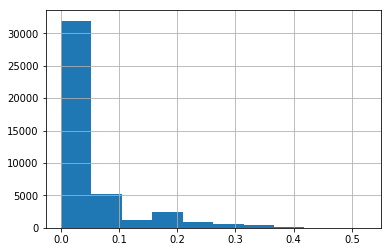

In [364]:
predic_result_lr['RESPONSE'].hist()

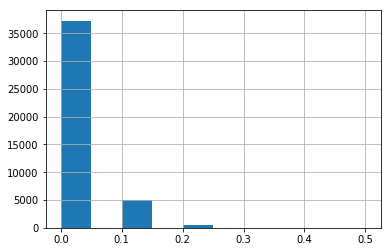

In [365]:
predic_result_rf['RESPONSE'].hist()

In order to increase the performace of the models, I tried to use PCA compoents only as my independent variables.

In [368]:
#  Subset test : X_pca_c_train, X_pca_c_test, y_pca_c_train, y_pca_c_test 
# Logistic Regression + GridSearch
lr_pca_c_parameter = {"C" : [0.00005, 0.0001, 0.0005]}
lr_pca_c_model = GridSearchCV(LogisticRegression(),param_grid=lr_pca_c_parameter,cv=5)

# 学習させる
lr_pca_c_model.fit(X_pca_c_train, y_pca_c_train)

y_pca_c_pred = lr_pca_c_model.predict(X_pca_c_test)

# Evaluation
evaluate_model(y_pca_c_test, y_pca_c_pred)

 Accuracy is 0.99
 Precision is 0.00
 Recall is 0.00
 F1 is 0.00
Confusion Matrix is:
[[14002     0]
 [  176     0]]


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [372]:
# Consider class weight
#  Subset test : X_pca_c_train, X_pca_c_test, y_pca_c_train, y_pca_c_test 
# Logistic Regression + GridSearch
weights = np.linspace(0.01, 0.99, 30)
lr_pca_c_parameter = {"C" : [0.00005, 0.0001, 0.0005], 'class_weight': [{0: x, 1: 1.0-x} for x in weights]}
lr_pca_c_model = GridSearchCV(LogisticRegression(), param_grid=lr_pca_c_parameter,cv=5)

# 学習させる
lr_pca_c_model.fit(X_pca_c_train, y_pca_c_train)

y_pca_c_pred = lr_pca_c_model.predict(X_pca_c_test)

# Evaluation
evaluate_model(y_pca_c_test, y_pca_c_pred)

 Accuracy is 0.99
 Precision is 0.00
 Recall is 0.00
 F1 is 0.00
Confusion Matrix is:
[[14002     0]
 [  176     0]]


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [369]:
# RandomForest + GridSearch
rf_pca_c_parameter = {'n_estimators'  : [3, 10, 100, 1000, 10000]}
rf_pca_c_model = GridSearchCV(RandomForestClassifier(), param_grid=rf_pca_c_parameter,cv=5)

# 学習させる
rf_pca_c_model.fit(X_pca_c_train, y_pca_c_train)

y_pca_c_pred = rf_pca_c_model.predict(X_pca_c_test)

# Evaluation
evaluate_model(y_pca_c_test, y_pca_c_pred)

 Accuracy is 0.99
 Precision is 0.00
 Recall is 0.00
 F1 is 0.00
Confusion Matrix is:
[[14002     0]
 [  176     0]]


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In order to increase the performace of the models, I tried to increase the PCA componets to 20 componets.

In [376]:
# PCA 20
pca_decided_PCA20 = PCA(n_components=20)
pca_decided_PCA20.fit(X=azdias_informative_dummy_nonan_scaled)

pca_transformed_PCA20 = pca_decided_PCA20.transform(azdias_informative_dummy_nonan_scaled)

kmeans = KMeans(30)
kmeans_model_PCA30 = kmeans.fit(pca_transformed_PCA20)  


# mailout_train data

# PCA & KMeans
print('** PCA  & KMeans prediction **')
mailout_train_transformed_PCA20 = pca_decided_PCA20.transform(mailout_train_informative_dummy_nonan_scaled)
mailout_train_clusters_PCA30 = kmeans_model_PCA30.predict(mailout_train_transformed_PCA20)


# Combine the PCA and cluster data
mailout_train_pca_clusters_PCA30 = pd.DataFrame({ 'PCA_1': mailout_train_transformed_PCA20[:, 0],
                             'PCA_2': mailout_train_transformed_PCA20[:, 1],
                             'PCA_3': mailout_train_transformed_PCA20[:, 2],
                             'PCA_4': mailout_train_transformed_PCA20[:, 3],
                             'PCA_5': mailout_train_transformed_PCA20[:, 4],
                              'PCA_6': mailout_train_transformed_PCA20[:, 5],
                              'PCA_7': mailout_train_transformed_PCA20[:, 6],
                              'PCA_8': mailout_train_transformed_PCA20[:, 7],
                              'PCA_9': mailout_train_transformed_PCA20[:, 8],
                              'PCA_10': mailout_train_transformed_PCA20[:, 9],
                              'PCA_11': mailout_train_transformed_PCA20[:, 10],
                              'PCA_12': mailout_train_transformed_PCA20[:, 11],
                              'PCA_13': mailout_train_transformed_PCA20[:, 12],
                              'PCA_14': mailout_train_transformed_PCA20[:, 13],
                              'PCA_15': mailout_train_transformed_PCA20[:, 14],
                              'PCA_16': mailout_train_transformed_PCA20[:, 15],
                              'PCA_17': mailout_train_transformed_PCA20[:, 16],
                              'PCA_18': mailout_train_transformed_PCA20[:, 17],
                              'PCA_19': mailout_train_transformed_PCA20[:, 18],
                              'PCA_20': mailout_train_transformed_PCA20[:, 19],
                             'cluster': mailout_train_clusters_PCA30})



# Inorder to evaluate models, separate the mailout_train data into Train and Test data
X_pca_c_train, X_pca_c_test, y_pca_c_train, y_pca_c_test = train_test_split(mailout_train_pca_clusters_PCA30, mailout_train_response, test_size=0.33, random_state=1, stratify=mailout_train_response)                             



# Consider class weight
#  Subset test : X_pca_c_train, X_pca_c_test, y_pca_c_train, y_pca_c_test 
# Logistic Regression + GridSearch
weights = np.linspace(0.01, 0.99, 10)
lr_pca_c_parameter = {"C" : [0.00005, 0.0001, 0.0005], 'class_weight': [{0: x, 1: 1.0-x} for x in weights]}
lr_pca_c_model = GridSearchCV(LogisticRegression(), param_grid=lr_pca_c_parameter,cv=5)

# 学習させる
lr_pca_c_model.fit(X_pca_c_train, y_pca_c_train)

y_pca_c_pred = lr_pca_c_model.predict(X_pca_c_test)

# Evaluation
evaluate_model(y_pca_c_test, y_pca_c_pred)

** PCA  & KMeans prediction **
 Accuracy is 0.99
 Precision is 0.00
 Recall is 0.00
 F1 is 0.00
Confusion Matrix is:
[[14001     1]
 [  176     0]]


In [382]:
# Evaluate the final test data

# PCA & KMeans
print('** PCA  & KMeans prediction **')
mailout_test_transformed_PCA20 = pca_decided_PCA20.transform(mailout_test_informative_dummy_nonan_scaled)
mailout_test_clusters_PCA20 = kmeans_model_PCA30.predict(mailout_test_transformed_PCA20)


# Combine the PCA and cluster data
mailout_train_pca_clusters_PCA20 = pd.DataFrame({ 'PCA_1': mailout_test_transformed_PCA20[:, 0],
                             'PCA_2': mailout_test_transformed_PCA20[:, 1],
                             'PCA_3': mailout_test_transformed_PCA20[:, 2],
                             'PCA_4': mailout_test_transformed_PCA20[:, 3],
                             'PCA_5': mailout_test_transformed_PCA20[:, 4],
                              'PCA_6': mailout_test_transformed_PCA20[:, 5],
                              'PCA_7': mailout_test_transformed_PCA20[:, 6],
                              'PCA_8': mailout_test_transformed_PCA20[:, 7],
                              'PCA_9': mailout_test_transformed_PCA20[:, 8],
                              'PCA_10': mailout_test_transformed_PCA20[:, 9],
                              'PCA_11': mailout_test_transformed_PCA20[:, 10],
                              'PCA_12': mailout_test_transformed_PCA20[:, 11],
                              'PCA_13': mailout_test_transformed_PCA20[:, 12],
                              'PCA_14': mailout_test_transformed_PCA20[:, 13],
                              'PCA_15': mailout_test_transformed_PCA20[:, 14],
                              'PCA_16': mailout_test_transformed_PCA20[:, 15],
                              'PCA_17': mailout_test_transformed_PCA20[:, 16],
                              'PCA_18': mailout_test_transformed_PCA20[:, 17],
                              'PCA_19': mailout_test_transformed_PCA20[:, 18],
                              'PCA_20': mailout_test_transformed_PCA20[:, 19],
                             'cluster': mailout_test_clusters_PCA20})


prediction_lr_PCA20 = lr_pca_c_model.predict_proba(mailout_train_pca_clusters_PCA20)[:, 1]
predic_result_lr_PCA20 = pd.DataFrame(data={'LNR' : mailout_test_informative_dummy_LNR, 'RESPONSE' : prediction_lr_PCA20})

predic_result_lr_PCA20.to_csv('predic_result_lr_PCA20.csv', index=False)

** PCA  & KMeans prediction **
